In [1]:
# Ignore warnings
import warnings

warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.optimize import minimize
from scipy.stats import norm
from statsmodels.tsa.stattools import adfuller

In [2]:
def download_data(ticker, start_date="2014-01-01"):
    # download ticker data from yfinance library
    df = yf.download(ticker, start=start_date)
    df.dropna(inplace=True)
    return df

# Download data
ticker1 = "KO"
ticker2 = "PEP"
df_ko = download_data(ticker1)
df_pep = download_data(ticker2)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
df_ko.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,41.119999,41.230000,40.509998,40.660000,29.140591,12698600
2014-01-03,40.680000,40.730000,40.349998,40.459999,28.997248,10403400
2014-01-06,40.480000,40.590000,40.160000,40.270000,28.861076,11036300
2014-01-07,40.480000,40.720001,40.290001,40.389999,28.947077,11872300
2014-01-08,40.439999,40.439999,39.830002,39.939999,28.624563,15339600


In [4]:
df_pep.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,82.930000,82.989998,81.820000,82.099998,60.635098,3275900
2014-01-03,82.120003,82.870003,82.120003,82.239998,60.738476,3287200
2014-01-06,82.199997,82.610001,82.080002,82.279999,60.768040,3888400
2014-01-07,82.620003,83.989998,82.610001,83.480003,61.654301,6332400
2014-01-08,83.330002,83.620003,82.809998,83.239998,61.477036,5653300


In [5]:
def prepare_time_series(data1, data2, ticker1, ticker2, index_ticker="SPY"):
    # download index data
    index_data = download_data(index_ticker)

    # among the 3 dataframes: determine latest start date and trim all dataframes to start there
    latest_start_date = max(data1.index.min(), data2.index.min(), index_data.index.min())
    data1 = data1[data1.index >= latest_start_date]
    data2 = data2[data2.index >= latest_start_date]
    index_data = index_data[index_data.index >= latest_start_date]

    # combine the 3 trimmed dataframes into 1
    data = pd.concat([data1['Close'], data2['Close'], index_data['Close']], axis=1).dropna()

    data.columns = [ticker1, ticker2, index_ticker]
    return data

data = prepare_time_series(df_ko, df_pep, ticker1, ticker2)
data.head()

[*********************100%%**********************]  1 of 1 completed


,KO,PEP,SPY
Date,,,
2014-01-02,40.660000,82.099998,182.919998
2014-01-03,40.459999,82.239998,182.889999
2014-01-06,40.270000,82.279999,182.360001
2014-01-07,40.389999,83.480003,183.479996
2014-01-08,39.939999,83.239998,183.520004


# Engle-Granger method: Cointegration analysis between time series

## Step 1: Residual anaylsis between price time series $X_t, Y_t$


1. **Linear regression of $X_t$ onto $Y_t$ to describe long-term equilibrium relationship**:

The regression equation is: $$Y_t = \beta_0 + \beta_1 X_t + e_t$$ where $e_t$ is the residual.


2. **ADF Test on Residuals:**

It follows from the regression equation that $$e_t = Y_t - \beta_0 - \beta_1 X_t.$$ If $X_t$ and $Y_t$ are cointegrated, then the residuals $e_t$ must be stationary. To find out whether a time series is stationary, we conduct the *Augmented Dickey-Fuller (ADF) test* to check for stationarity of $e_t$.

The *ADF test* checks for unit roots in time series. The null hypothesis is that the tested time series $e_t$ has a unit root and is therefore non-stationary. If the p-value is below a certain significant value (e.g. 5% or 1%), we reject the null hypothesis, indicating that the series is stationary.

In [6]:
def least_squares_regression(y, X):
    """Perform least squares regression to obtain beta coefficients and residuals."""
    X = np.hstack([np.ones((X.shape[0], 1)), X])  # add y-intercept to X
    beta = np.linalg.inv(X.T @ X) @ (X.T @ y)  # least sqaures regression into coefficient vector beta
    residuals = y - X @ beta
    return beta, residuals


# Perform ordinary least square (OLS) regression
y = data[ticker1].values
X = data[ticker2].values.reshape(-1, 1)
beta, residuals = least_squares_regression(y, X)
data['residuals'] = residuals
data.head()

,KO,PEP,SPY,residuals
Date,,,,
2014-01-02,40.660000,82.099998,182.919998,2.563554
2014-01-03,40.459999,82.239998,182.889999,2.329098
2014-01-06,40.270000,82.279999,182.360001,2.129254
2014-01-07,40.389999,83.480003,183.479996,1.953916
2014-01-08,39.939999,83.239998,183.520004,1.562984


In [7]:
beta  # i.e. KO_t = beta[0] + beta[1] * PEP_t + e_t

array([17.89053394,  0.24611342])

In our case, writing $\beta = \left(\beta_0, \beta_1\right) \approx \left(17.9, 0.25\right)$**############### update numbers here!**, the linear regression yields the following relationship between the time series of KO and PEP: $$\text{KO}_t = \beta_0 + \beta_1 \text{PEP}_t + e_t,$$ where $e_t$ denotes the time series of residuals in the dataframe, also shown here:

In [8]:
data['residuals']

Date
2014-01-02    2.563554
2014-01-03    2.329098
2014-01-06    2.129254
2014-01-07    1.953916
2014-01-08    1.562984
                ...   
2024-08-05    7.375886
2024-08-06    7.707363
2024-08-07    8.289642
2024-08-08    8.416900
2024-08-09    8.361973
Name: residuals, Length: 2669, dtype: float64

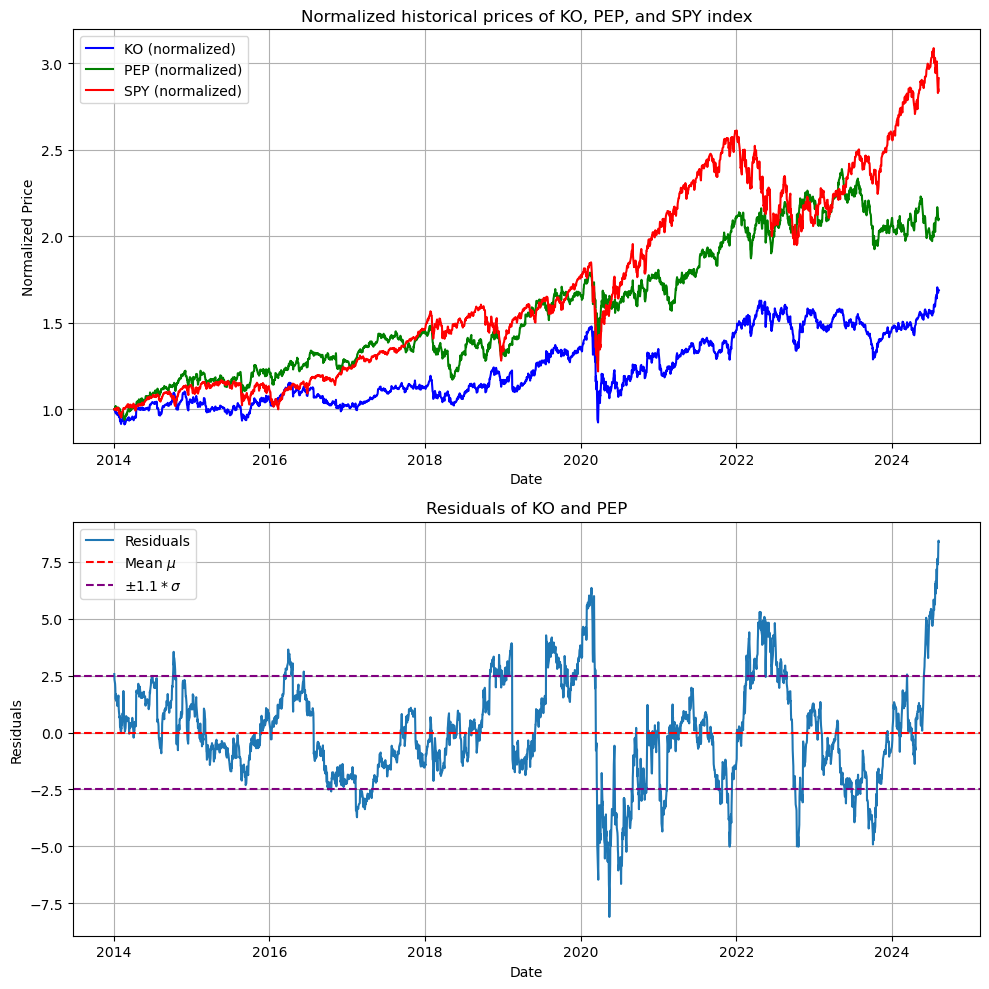

In [9]:
def plot_assets_and_residuals(data, ticker1, ticker2, index_ticker="SPY"):
    plt.figure(figsize=(10, 10))

    # normalize historical prices
    normalized_ticker1 = data[ticker1] / data[ticker1].iloc[0]
    normalized_ticker2 = data[ticker2] / data[ticker2].iloc[0]
    normalized_index = data[index_ticker] / data[index_ticker].iloc[0]

    # plot normalized prices
    plt.subplot(2, 1, 1)
    plt.plot(data.index, normalized_ticker1, label=f"{ticker1} (normalized)", color="b")
    plt.plot(data.index, normalized_ticker2, label=f"{ticker2} (normalized)", color="g")
    plt.plot(data.index, normalized_index, label=f"{index_ticker} (normalized)", color="r")
    plt.title(f"Normalized historical prices of {ticker1}, {ticker2}, and {index_ticker} index")
    plt.xlabel("Date")
    plt.ylabel("Normalized Price")
    plt.legend()
    plt.grid(True)

    # plot residuals
    plt.subplot(2, 1, 2)
    plt.plot(data.index, data['residuals'], label="Residuals")
    mean = data['residuals'].mean()
    stdev = data['residuals'].std()
    plt.axhline(mean, color="r", linestyle='--', label=f"Mean $\mu$")
    plt.axhline(mean + 1.1 * stdev, color="purple", linestyle="--", label="$\pm1.1*\sigma$")
    plt.axhline(mean - 1.1 * stdev, color="purple", linestyle="--")
    plt.title(f"Residuals of {ticker1} and {ticker2}")
    plt.xlabel("Date")
    plt.ylabel("Residuals")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


plot_assets_and_residuals(data, ticker1, ticker2)

In [10]:
def perform_adf_test(residuals, significance_level):
    """Perform the Augmented Dickey-Fuller (ADF) test to check for the presence of unit root in a time series.
    H0: time series has a unit root (i.e. non-stationary)"""
    adf_test = adfuller(residuals)
    adf_statistic, p_value = adf_test[0], adf_test[1]

    print(f"ADF Statistic: {adf_statistic:.4f}")
    print(f"p-value: {p_value:.4f}")

    if p_value < significance_level:
        print(f"The residuals are stationary (reject null hypothesis) "
              f"at the {significance_level * 100}% significance level.")
    else:
        print(f"The residuals are not stationary (accept null hypothesis) "
              f"at the {significance_level * 100}% significance level.")
    return adf_test


adf_test_result = perform_adf_test(data['residuals'], significance_level=0.05)

ADF Statistic: -3.6793
p-value: 0.0044
The residuals are stationary (reject null hypothesis) at the 5.0% significance level.


### Conclusion of Engle-Granger Step 1 for the example of KO and PEP

The regression model following $$Y_t = \beta_0 + \beta_1 X_t + e_t$$ yields $$\text{KO}_t = \beta_0 + \beta_1 \text{PEP}_t + e_t$$ with $\beta = \left(\beta_0, \beta_1\right) \approx \left(17.9, 0.25\right)$ for our case.**############## Update numbers here**

The Augmented Dickey-Fuller test displayed a very low p-value. We therefore strongly reject the null hypothesis of a unit root at both 5% and 1% significance level, implying that the time series of KO and PEP are cointegrated.

#### Coefficients analysis

$\beta_0$ as the intercept describes the part of KO's price that is independent of PEP.

$\beta_1$ models the linear dependency between KO and PEP in the long-term equilibrium. In practice, this can be used as a hedge ratio, because for every unit change in PEP's price, KO prices will increase by $\beta_1\approx 0.25$**############## Update numbers here** on average.

## Step 2 of Engle-Granger: ECM

The ECM now considers the absolute returns (differences) $\Delta X_t = X_t - X_{t-1}$ (e.g., PEP) and $\Delta Y_t = Y_t - Y_{t-1}$ (e.g., KO). Considering such differences removes long-term continuous effects and is more suitable to analyze short-term dynamics.

The Equilibrium Correction Model (ECM) classically follows the equation
$$\Delta Y_t =\alpha_0+\alpha_1 \cdot \Delta X_t + \alpha_2\cdot e_{t-1}+\varepsilon_t,$$
where
* $e_{t-1}$ denotes the lagged residuals from the previous cointegration regression.
* $\alpha=\left(\alpha_0, \alpha_1, \alpha_2\right)$ is the coefficient of the ECM regression. In particular, $\alpha_2$ is the error correction term coefficient of the residual term $e_{t-1}$, representing the speed of adjustment towards the long-term equilibrium.
* $\varepsilon_t$ denotes the "new" residual terms, inferred from regressing the ECM.

In [11]:
def get_differences(data, columns):
    """Calculate the returns (differences) Delta y_t = y_t-y_{t-1} for the specified columns in the dataframe."""
    return data[columns].diff().dropna()


def fit_ecm(data, residuals_column, target_column, independent_column):
    """Step2 of the Engle-Granger procedure: fit the Equilibrium Correction Model (ECM)."""
    data_delta = get_differences(data, [target_column, independent_column])
    data_delta['lagged_residuals'] = data[residuals_column].shift(1)  # lag the residuals
    data_delta = data_delta.dropna()

    # OLS to obtain ECM coefficients & residuals
    y = data_delta[target_column].values
    X = data_delta[[independent_column, "lagged_residuals"]].values
    ecm_coefficients, ecm_residuals = least_squares_regression(y, X)

    ecm_residuals = pd.DataFrame(ecm_residuals, index=data_delta.index, columns=["ECM_residuals"])  # convert to pd.df
    return {'coefficients': ecm_coefficients, 'residuals': ecm_residuals}


# Fit the ECM for KO and PEP
ecm_results = fit_ecm(data, "residuals", ticker1, ticker2)
print("ECM Coefficients:", ecm_results['coefficients'])
print("ECM Residuals:", ecm_results['residuals'])

ECM Coefficients: [ 0.00137345  0.26864038 -0.01196964]
ECM Residuals:             ECM_residuals
Date                     
2014-01-03      -0.208299
2014-01-06      -0.174239
2014-01-07      -0.178258
2014-01-08      -0.363511
2014-01-09      -0.087895
...                   ...
2024-08-05      -0.065589
2024-08-06       0.453307
2024-08-07       0.688929
2024-08-08       0.212043
2024-08-09       0.043997

[2668 rows x 1 columns]


### Conclusion of Engle-Granger Step 2 for the example of KO and PEP

The ECM regression for the considered example can be formulated as
$$\Delta\text{KO}_t = \alpha_0 + \alpha_1 \Delta\text{PEP}_t + \alpha_2 e_{t-1} + \varepsilon_t$$
with $\alpha = \left(\alpha_0, \alpha_1, \alpha_2\right) \approx \left(0.00, 0.27, -0.01\right)$**############### update numbers here!**.

#### Coefficients analysis

$\alpha_1$ is the coefficient that best describes the linear relationship between KO and PEP for shorter-term periods. It signifies that a unit change in $\Delta X_t = \Delta\text{PEP}_t$ results in a $\alpha_1\approx 0.27$**############### update numbers here!** change in $\Delta Y_t = \Delta\text{KO}_t$.

The negative sign of $\alpha_2\approx -0.01$**############### update numbers here!** indicates a mean-reversion towards the long-term mean since it suggests a tendency to correct deviations from the equilibrium.

#### Residuals comparison

While the previously calculated residuals $e_t$ represent deviations from the long-term equilibrium between KO and PEP, the ECM residual time series $\varepsilon_t$ represent deviations in the changes in KO prices after accounting for changes in PEP prices, with short-term dynamics and mean-reverting behavior removed from the model.

Therefore, $\varepsilon_t$ should expectedly be lower in magnitude than the long-term equilibrium residuals $e_t$ and hover closely around $0$ with no obvious patterns - similar to white noise residuals, reflecting that most of the short-term dynamics and mean-reverting corrections to the long-term mean have already been accounted for.

Indeed a plot shows the described behaviour:

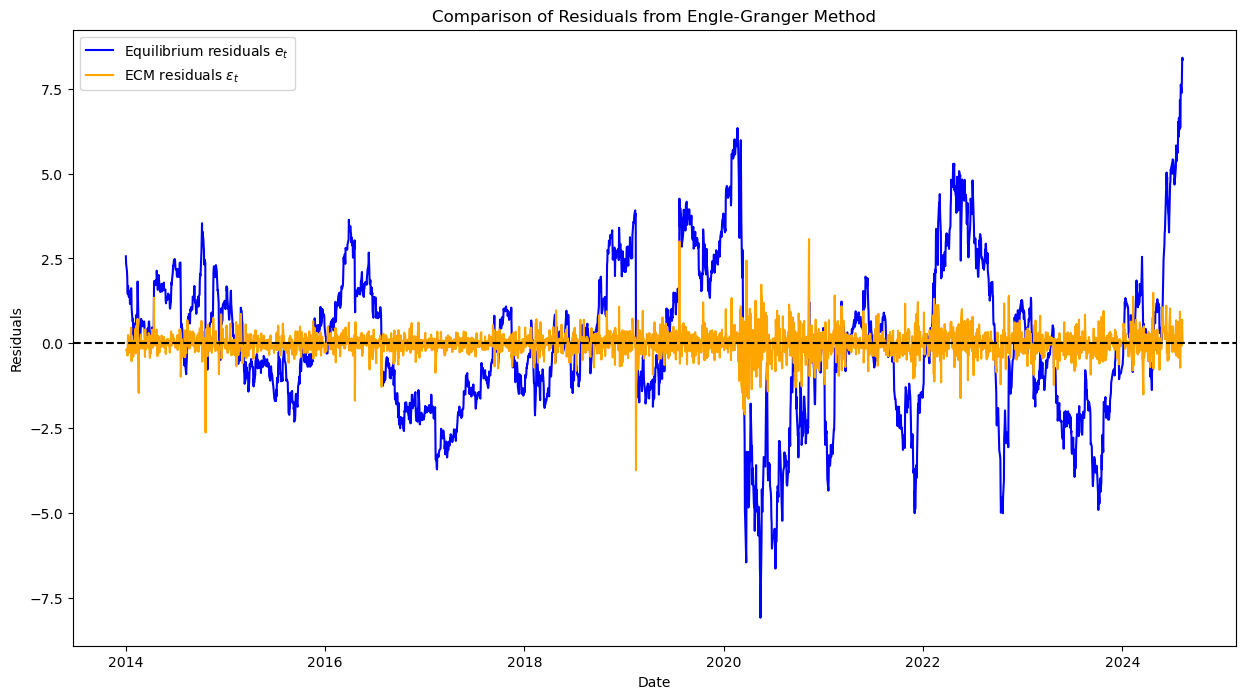

In [12]:
plt.figure(figsize=(15, 8))
plt.plot(data.index, data['residuals'], label="Equilibrium residuals $e_t$", color="blue")
# Align indices for lagged epsilon residuals
plt.plot(data.index[1:], ecm_results['residuals'], label="ECM residuals $\epsilon_t$", color="orange")
plt.axhline(0, color='black', linestyle='--')
plt.title("Comparison of Residuals from Engle-Granger Method")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.legend()
plt.show()

## Step 3 (inofficial): Ornstein-Uhlenbeck process for mean-reverting residuals

$$d e_t = -\theta (e_t - \mu_e) dt + \sigma_{OU} dX_t,$$ where $\theta$ is the speed of mean-reversion to long-term equilibrium mean $\mu_e$ and $\sigma_{OU}$ is the standard deviation (volatility) of the process.


In [13]:
def ou_likelihood(params, residuals, dt):
    """Calculates the negative log-likelihood of an Ornstein-Uhlenbeck process"""
    theta, mu_e, sigma_ou = params
    likelihood = 0
    for t in range(1, len(residuals)):
        mean = residuals[t-1] + theta * (mu_e - residuals[t-1]) * dt
        variance = sigma_ou**2 * dt
        # increment the log likelihood (=log probability density) with mean and variance of the next residual
        likelihood += norm.logpdf(residuals[t], loc=mean, scale=np.sqrt(variance))
    return -likelihood


def estimate_ou_params(residuals, dt=1):  # dt = 1: daily prices, so usually time increment dt = 1
    """Estimate Ornstein-Uhlenbeck process parameters using maximum likelihood estimation.
    The OU process is given as: d(residuals)_t = -theta (residuals_t-mu_e) dt + sigma_ou dX_t"""
    residuals = np.array(residuals)
    initial_params = [0.1, np.mean(residuals), np.std(residuals)]  # [theta0, mu_ou0, sigma_ou0]
    # we minimize negative log-likelihood, which is equivalent to using maximum likelihood estimator (MLE)
    result = minimize(ou_likelihood, initial_params, args=(residuals, dt), method="L-BFGS-B")
    theta, mu_e, sigma_ou = result.x
    return theta, mu_e, sigma_ou


theta, mu_e, sigma_ou = estimate_ou_params(data['residuals'])
print(f"Estimated OU parameters: theta={theta:.4f}, mu_e={mu_e:.4f}, sigma_ou={sigma_ou:.4f}")

Estimated OU parameters: theta=0.0123, mu_e=0.1735, sigma_ou=0.3814


In [14]:
ou_params = {'theta': theta, 'mu_e': mu_e, 'sigma_ou': sigma_ou}

### Visualizing the simulated OU process against the actual residuals $e_t$:

Simulation of Ornstein-Uhlenbeck process with the estimated parameters $(\theta, \mu_e, \sigma_{ou})\approx \left(0.0123, 0.1751, 0.3815\right)$**############### update numbers here!** should display similar dynamics as the ectual residuals time series $e_t$. However, some deviations from the original residual time series $e_t$ are still expected, since the OU process is a continuous-time stochastic process simulated from an SDE including Brownian increments (randomness).

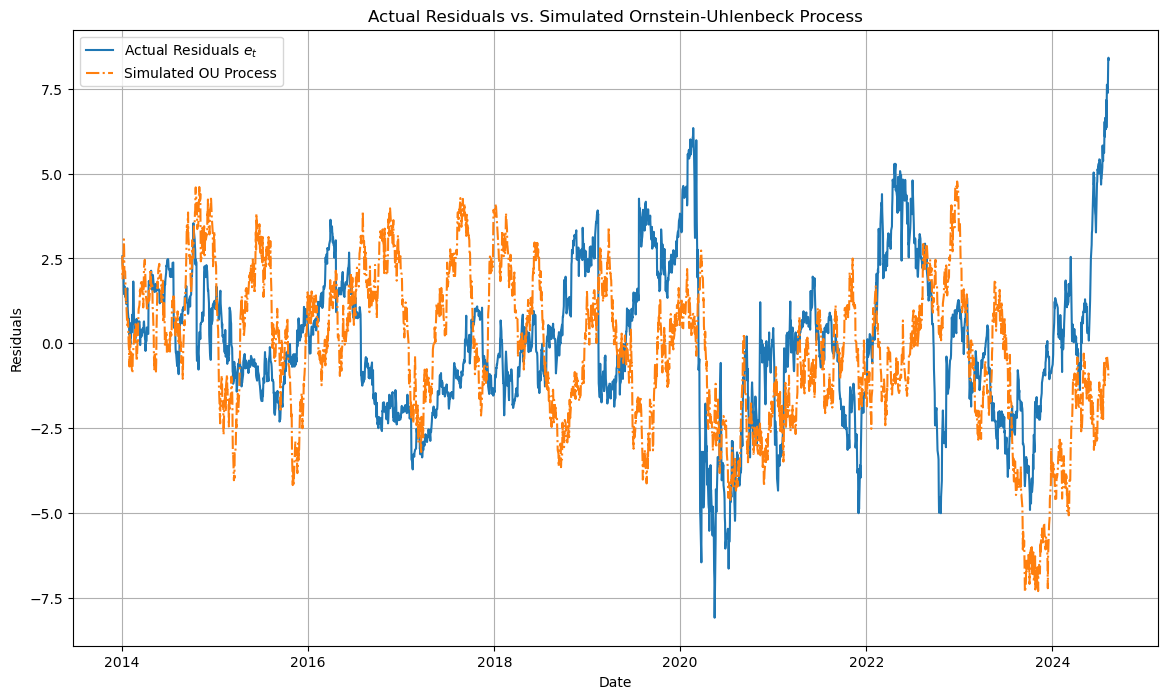

In [15]:
def simulate_ou_process(theta, mu_e, sigma_ou, initial_value, num_steps, dt=1):
    """Simulate an Ornstein-Uhlenbeck process."""
    ou_process = np.zeros(num_steps)
    ou_process[0] = initial_value
    for t in range(1, num_steps):
        ou_process[t] = ou_process[t-1] + theta * (mu_e - ou_process[t-1]) * dt + sigma_ou * np.sqrt(dt) * np.random.normal()
    return ou_process

# Simulate an OU process with the estimated parameters
num_steps = len(data['residuals'])
initial_value = data['residuals'].iloc[0]
simulated_residuals = simulate_ou_process(theta, mu_e, sigma_ou, initial_value, num_steps)

# Plot the actual residuals and the simulated OU process
plt.figure(figsize=(14, 8))
plt.plot(data.index, data['residuals'], label="Actual Residuals $e_t$")
plt.plot(data.index, simulated_residuals, label="Simulated OU Process", linestyle="-.")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.title("Actual Residuals vs. Simulated Ornstein-Uhlenbeck Process")
plt.legend()
plt.grid(True)
plt.show()

In [16]:
print(f"Half-life of OU process: {np.log(2)/theta:.2f} trading days") 

Half-life of OU process: 56.32 trading days


# Trading strategy based on mean-reversion analysis

Using $\beta_1$ as hedge ratio as previously discussed...

In [17]:
hedge_ratio = beta[1]

In [29]:
class Portfolio:
    def __init__(self, data, ticker1, ticker2, ou_params, hedge_ratio, z):
        self.data = data
        self.ticker1 = ticker1
        self.ticker2 = ticker2
        self.theta = ou_params['theta']
        self.sigma_ou = ou_params['sigma_ou']
        self.mu_e = ou_params['mu_e']
        self.hedge_ratio = hedge_ratio
        self.z = z
        self.pnl = []
        self.positions = []
        self.returns = []

    def calculate_optimal_bounds(self):
        """Calculate the upper and lower bounds for trading, CQF FP Workshop 2, sl. 15."""
        sigma_eq = self.sigma_ou / np.sqrt(2 * self.theta)
        upper_bound = self.mu_e + self.z * sigma_eq
        lower_bound = self.mu_e - self.z * sigma_eq
        return upper_bound, lower_bound

    def enter_position(self, row, position_ticker1, position_ticker2):
        """Enter a position based on the current market conditions."""
        entry_price_ticker1 = row[self.ticker1]
        entry_price_ticker2 = row[self.ticker2]
        self.positions.append((position_ticker1, position_ticker2, entry_price_ticker1, entry_price_ticker2))
        return position_ticker1, position_ticker2, entry_price_ticker1, entry_price_ticker2

    def calculate_trade_pnl(self, row, position_ticker1, position_ticker2, entry_price_ticker1, entry_price_ticker2):
        """Calculate the PnL of the trade."""
        if position_ticker1 == 1 and position_ticker2 == -self.hedge_ratio:
            trade_pnl = (row[self.ticker1] - entry_price_ticker1) + (entry_price_ticker2 - row[self.ticker2]) * self.hedge_ratio
        elif position_ticker1 == -1 and position_ticker2 == self.hedge_ratio:
            trade_pnl = (entry_price_ticker1 - row[self.ticker1]) + (row[self.ticker2] - entry_price_ticker2) * self.hedge_ratio
        else:
            trade_pnl = 0
        return trade_pnl

    def append_return(self, trade_pnl, entry_price_ticker1, entry_price_ticker2):
        """Append the return (either simple or log) to the self.returns list."""
        simple_return = trade_pnl / (entry_price_ticker1 + self.hedge_ratio * entry_price_ticker2)
        self.returns.append(simple_return)

    def close_position(self, row, position_ticker1, position_ticker2, entry_price_ticker1, entry_price_ticker2):
        """Close the position and calculate the PnL and return."""
        trade_pnl = self.calculate_trade_pnl(row, position_ticker1, position_ticker2, entry_price_ticker1, entry_price_ticker2)
        if trade_pnl != 0:
            self.pnl.append(trade_pnl)
            self.append_return(trade_pnl, entry_price_ticker1, entry_price_ticker2)
        return 0, 0, 0, 0  # reset positions and entry prices

    def manage_positions(self):
        """Manage positions for the trading strategy exploiting mean-reversion of 2 cointegrated assets using
        hedge ratio (beta1) previously obtained in Engle-Granger step 1 and track PnL."""
        position_ticker1, position_ticker2, entry_price_ticker1, entry_price_ticker2 = 0, 0, 0, 0
        upper_bound, lower_bound = self.calculate_optimal_bounds()

        for index, row in self.data.iterrows():
            residual = row['residuals']

            # entry conditions
            if position_ticker1 == 0 and position_ticker2 == 0:
                if residual > upper_bound:  # very positive spread
                    # short ticker1 (over-valued from equilibrium), long ticker2
                    position_ticker1, position_ticker2 = -1, self.hedge_ratio
                elif residual < lower_bound:  # very negative spread
                    # long ticker1 (under-valued from equilibrium), short ticker2
                    position_ticker1, position_ticker2 = 1, -self.hedge_ratio
                position_ticker1, position_ticker2, entry_price_ticker1, entry_price_ticker2 = \
                    self.enter_position(row, position_ticker1, position_ticker2)

            # exit conditions -> close positions
            elif (position_ticker1 == 1 and position_ticker2 == -self.hedge_ratio and residual >= self.mu_e) or \
                 (position_ticker1 == -1 and position_ticker2 == self.hedge_ratio and residual <= self.mu_e):
                position_ticker1, position_ticker2, entry_price_ticker1, entry_price_ticker2 = \
                    self.close_position(row, position_ticker1, position_ticker2, entry_price_ticker1, entry_price_ticker2)

        return np.sum(self.pnl)


class RiskMetrics:
    def __init__(self, returns):
        self.returns = returns

    def calculate_var(self, confidence_level=0.95):
        """Calculate Value at Risk (VaR) at the given confidence level."""
        if len(self.returns) > 0:
            var = np.percentile(self.returns, (1 - confidence_level) * 100)
        else:
            var = 0
        return var

    def calculate_expected_shortfall(self, confidence_level=0.95):
        """Calculate Expected Shortfall (ES) at the given confidence level."""
        var = self.calculate_var(confidence_level)
        if len(self.returns) > 0:
            expected_shortfall = np.mean([r for r in self.returns if r < var])
        else:
            expected_shortfall = 0
        return expected_shortfall

    def run_full_analysis(self):
        return {'VaR': self.calculate_var(),
                'ES': self.calculate_expected_shortfall()}

In [30]:
def evaluate_pairs_trading_strategy(data, ticker1, ticker2, ou_params, hedge_ratio):
    """Test Z values in range [0.3, ..., 1.4] and select the best one"""
    results = []
    for z in np.arange(0.3, 1.5, 0.1):
        portfolio = Portfolio(data, ticker1, ticker2, ou_params, hedge_ratio, z)
        pnl = portfolio.manage_positions()
        risk_metrics = RiskMetrics(portfolio.returns)
        var = risk_metrics.calculate_var()
        es = risk_metrics.calculate_expected_shortfall()
        results.append({'Z': z, 'PnL': pnl, 'VaR': var, 'ES': es})
    return pd.DataFrame(results)


backtest_results = evaluate_pairs_trading_strategy(data, ticker1, ticker2, ou_params, hedge_ratio)
backtest_results

,Z,PnL,VaR,ES
0,0.3,59.037301,0.008398,0.008140
1,0.4,56.742067,0.010497,0.010209
2,0.5,47.295997,0.013993,0.012871
3,0.6,55.536649,0.016517,0.016077
4,0.7,53.071155,0.017756,0.016626
5,0.8,53.525869,0.020838,0.019916
6,0.9,48.120487,0.023772,0.022327
7,1.0,40.406537,0.026955,0.022327
8,1.1,39.102234,0.028060,0.025526
9,1.2,43.368042,0.029579,0.028576


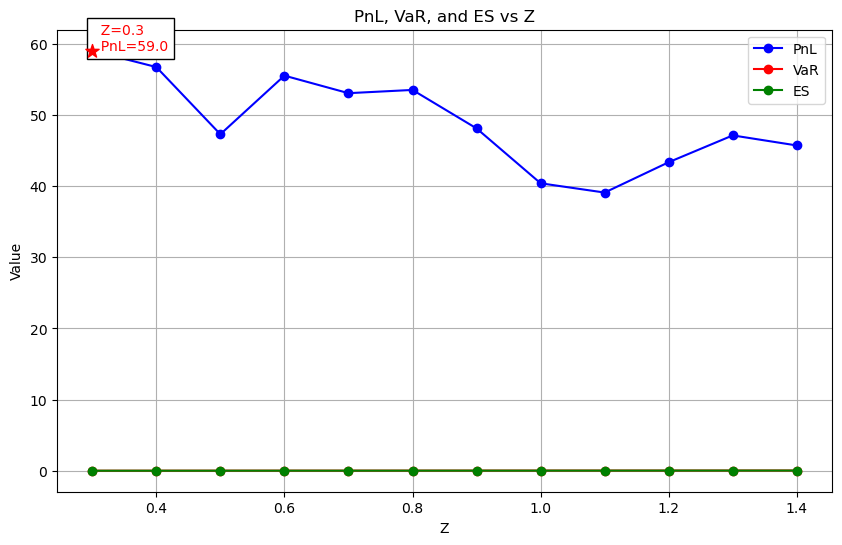

In [31]:
def find_best_pnl(pnl_table):
    # find the best PnL value and its corresponding Z
    best_row = pnl_table.loc[pnl_table['PnL'].idxmax()]
    return best_row['Z'], best_row['PnL']

plt.figure(figsize=(10, 6))

# Plotting PnL, VaR, and ES
plt.plot(backtest_results['Z'], backtest_results['PnL'], marker="o", linestyle="-", color="b", label="PnL")
plt.plot(backtest_results['Z'], backtest_results['VaR'], marker="o", linestyle="-", color="r", label="VaR")
plt.plot(backtest_results['Z'], backtest_results['ES'], marker="o", linestyle="-", color="g", label="ES")

# Highlight the best PnL point with a star
best_z, best_pnl = find_best_pnl(backtest_results)
plt.scatter(best_z, best_pnl, color='r', marker="*", s=100, zorder=5)

# Add text annotation to best PnL
plt.text(best_z, best_pnl, f"  Z={best_z:.1f}\n  PnL={best_pnl:.1f}", color="r", bbox=dict(facecolor="white"))

# Updated title and axis labels to be more generic
plt.title("PnL, VaR, and ES vs Z")
plt.xlabel("Z")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

In [32]:
sample_returns = [0.039624204456078005, 0.019020962830108377, 0.029226763637665028, 0.020836864859666085, 0.025632878251824944, 0.022131360737073637, 0.016323098887407368, 0.01921609541325636, 0.0320685379860958, 0.019629315804330482, 0.013323943464069298, 0.018693842949132688, 0.01996684299788384, 0.015332808589866678, 0.025556449898578405, 0.020650117004461226, 0.024295722994419486, 0.029855838071598945, 0.02095497470156078, 0.016787913619636035, 0.024192565353940182, 0.013092399494871431, 0.017975319722929425, 0.017870456238652566, 0.01324562531804528, 0.015857662152116966, 0.01172679248798324, 0.01319342808899236, 0.02252141574256499, 0.011035740349809194, 0.013024744887121844, 0.017571114146481038, 0.009938375826126852, 0.010479225120743304, 0.01219081263937764, 0.011861766282426973, 0.01597693229324757, 0.010500581564113962]
len(sample_returns)

sample_returns.sorted

38